# Project: Write a Data Science Blog Post

---

## Business Understanding

In this project, we will do the following: 

1.   Analyse a dataset.
2.   Pose three questions regarding the data.
3.   Publish the results of our analysis as a blog post on Medium.

This project will use the Airbnb London dataset available from [insideairbnb.com](http://insideairbnb.com/get-the-data.html). 

The business questions that will be discussed are given below:

1.   Which neighbourhoods have the most expensive listings in London?
2.   What features influence the price of an Airbnb listing?
3.   What is the percentage of positive reviews for the top 20 most reviewed listings in London?







## Data Understanding

The datasets used are available in two files: 
1.   listings.csv
2.   reviews.csv

The files are linked in the following GitHub repository [here](https://github.com/arvindcletus/data-science-repo/tree/main).

### Install the required packages

In [ ]:
# Un-comment and install the below packages if necessary
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install nltk
import nltk
nltk.download('vader_lexicon')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 10 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 

True

### Import packages

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline
sns.set_theme(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Read data from the source files into pandas dataframes





In [ ]:
# Read the data from Airbnb listings in Amsterdam into a Pandas DataFrame
f1_name='/content/drive/MyDrive/data-science/datasets/\
airbnb-london/listings.csv'
london_listings = pd.read_csv(f1_name)
df = london_listings.copy()

# Print the number of records in the DataFrame
print("No.of.records - {} \n".format(df.shape))
df.head()

No.of.records - (76984, 74) 



,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20201106040109,2020-11-07,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,Not even 10 minutes by metro from Victoria Sta...,https://a0.muscache.com/pictures/b7afccf4-18e5...,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Lambeth,NaN,51.46225,-0.11732,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,3.0,"[""Cable TV"", ""Coffee maker"", ""Carbon monoxide ...",$97.00,7,190,7,28,1125,1125,8.4,1125.0,NaN,t,0,0,4,279,2020-11-07,192,7,0,2010-03-21,2020-03-26,91.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,t,2,2,0,0,1.48
1,13913,https://www.airbnb.com/rooms/13913,20201106040109,2020-11-07,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a day,83%,71%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56802,-0.11121,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,0.0,"[""Cable TV"", ""Bed linens"", ""Coffee maker"", ""Pa...",$40.00,1,29,1,28,29,29,2.8,29.0,NaN,t,30,60,90,365,2020-11-07,21,2,0,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,NaN,f,2,1,1,0,0.17
2,15400,https://www.airbnb.com/rooms/15400,20201106040109,2020-11-07,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within a day,100%,100%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48796,-0.16898,Entire apartment,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Cable TV"", ""Coffee maker"", ""Dryer"", ""Dishes ...",$75.00,10,50,10,28,50,50,11.2,50.0,NaN,t,0,20,50,150,20

## Prepare the Data

In this step, we will do the following operations: 
1.   Identify categorial and numerical features. 
2.   Perform operations to clean the data.
3.   Create visualisations to explore the relationships of features within the dataset. 


### Identify Categorial and Numeric Columns

In [ ]:
# Identify numerical columns
num_vars = df.select_dtypes(include=['int', 'float'])
print("\nNo.of.numerical columns : {}".format(len(num_vars.columns)))


No.of.numerical columns : 41


In [ ]:
# Check to see the percentage of missing values in the numeric columns
(num_vars.isnull() / num_vars.shape[0]).sum().round(6) * 100

id                                                0.0000
scrape_id                                         0.0000
host_id                                           0.0000
host_listings_count                               0.0143
host_total_listings_count                         0.0143
neighbourhood_group_cleansed                    100.0000
latitude                                          0.0000
longitude                                         0.0000
accommodates                                      0.0000
bathrooms                                       100.0000
bedrooms                                          6.1649
beds                                              1.4029
minimum_nights                                    0.0000
maximum_nights                                    0.0000
minimum_minimum_nights                            0.0000
maximum_minimum_nights                            0.0000
minimum_maximum_nights                            0.0000
maximum_maximum_nights         

In [ ]:
# Identify categorical columns
categorical_vars = df.select_dtypes(include=['object'])
print("\nNo.of.categorical columns : {}".format(len(categorical_vars.columns)))


No.of.categorical columns : 33


In [ ]:
# Check to see the percentage of missing values in the categorical columns
(categorical_vars.isnull() / categorical_vars.shape[0]).sum().round(6) * 100

listing_url                0.0000
last_scraped               0.0000
name                       0.0299
description                3.9658
neighborhood_overview     37.8624
picture_url                0.0000
host_url                   0.0000
host_name                  0.0143
host_since                 0.0143
host_location              0.2481
host_about                43.8598
host_response_time        48.8647
host_response_rate        48.8647
host_acceptance_rate      36.9323
host_is_superhost          0.0143
host_thumbnail_url         0.0143
host_picture_url           0.0143
host_neighbourhood        24.1427
host_verifications         0.0000
host_has_profile_pic       0.0143
host_identity_verified     0.0143
neighbourhood             37.8611
neighbourhood_cleansed     0.0000
property_type              0.0000
room_type                  0.0000
bathrooms_text             0.2078
amenities                  0.0000
price                      0.0000
has_availability           0.0000
calendar_last_

### Perform operations to clean the data

In [ ]:
# Check to see if there exists columns whose values are similar or 
# can be computed from other columns in the dataset. If so, drop them.
# df = london_listings.copy()
assert(df['host_listings_count'].all() == df['host_total_listings_count'].all())
assert(df['host_id'].all() == df['calculated_host_listings_count'].all())

In [ ]:
# Drop column 'host_response_time' since half the values are NaNs
round(df.host_response_time.isna().sum()/df.host_response_time.shape[0],1)>=0.5

True

In [ ]:
# Exloring the feature 'bathrooms_text'. We see that different airbnb rentals 
# have varying numbers and types of bathrooms. Let's include this feature 
# in our analysis.
df['bathrooms_text'].unique()

array(['1 bath', '1 shared bath', '2 baths', '1 private bath',
       '1.5 shared baths', '1.5 baths', '0 shared baths', nan,
       '2.5 shared baths', '2 shared baths', '2.5 baths',
       'Shared half-bath', '4 baths', '3 baths', '0 baths',
       '3 shared baths', '3.5 baths', 'Half-bath', '5 baths', '4.5 baths',
       '5 shared baths', '3.5 shared baths', 'Private half-bath',
       '7 baths', '4 shared baths', '6 baths', '6 shared baths',
       '5.5 baths', '10 baths', '8.5 baths', '7 shared baths',
       '4.5 shared baths', '6.5 baths', '8 shared baths', '17 baths',
       '11 baths', '7.5 baths', '8 baths', '10.5 baths', '9 baths',
       '12 baths', '9 shared baths', '35 baths'], dtype=object)

In [ ]:
# Remove features that will not be used in the analysis
# df = london_listings.copy()
num_cols_to_drop = ['scrape_id', 'host_total_listings_count', 'license',
                    'calculated_host_listings_count', 'calendar_updated',
                    'calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms',
                    'calculated_host_listings_count_shared_rooms',
                    'availability_30', 'availability_60', 'availability_90',
                    'neighbourhood_group_cleansed', 'bathrooms',
                    'number_of_reviews_ltm', 'number_of_reviews_l30d'
                    ]

cat_cols_to_drop = ['listing_url', 'last_scraped', 'name', 'description',
                    'neighborhood_overview', 'picture_url', 'host_url', 
                    'host_name', 'host_about', 'host_thumbnail_url', 
                    'host_picture_url', 'host_neighbourhood', 'neighbourhood',
                    'first_review', 'last_review', 'host_location', 
                    'calendar_last_scraped', 'host_response_time', 
                    'host_verifications'
                    ]

drop_cols = num_cols_to_drop + cat_cols_to_drop

# Drop columns 
df.drop(columns=drop_cols, inplace=True)

#### Checkpoint - 1


In [ ]:
# Checkpoint - 1
df_cols_removed = df.copy()
df.shape

(76984, 40)

In [ ]:
# Check if df_cols_removed.shape == df.shape
assert(df_cols_removed.shape == df.shape)

In [ ]:
# Before cleaning the data, let's check for missing values
df.isna().sum()

id                                 0
host_id                            0
host_since                        11
host_response_rate             37618
host_acceptance_rate           28432
host_is_superhost                 11
host_listings_count               11
host_has_profile_pic              11
host_identity_verified            11
neighbourhood_cleansed             0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms_text                   160
bedrooms                        4746
beds                            1080
amenities                          0
price                              0
minimum_nights                     0
maximum_nights                     0
minimum_minimum_nights             0
maximum_minimum_nights             0
minimum_maximum_nights             0
maximum_maximum_nights             0
minimum_nights_avg_ntm             0
m

In [ ]:
# Function to clean the data
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe

    OUTPUT
    df['price'] - converted to a numeric value
    df['host_is_superhost'] - converted to a boolean value and NaNs filled with 
                            with value F
    df['host_has_profile_pic'] - converted to a boolean value
    df['host_identity_verified'] - converted to a boolean value
    df['has_availability'] - converted to a boolean value
    df['instant_bookable'] - converted to a boolean value
    df['host_acceptance_rate'] - converted to a numeric value, '%' removed and 
                               NaNs are filled with the mean value of the column
    df['host_response_rate'] - converted to a numeric value, '%' removed and 
                               NaNs are filled with the mean value of the column
    df['host_since'] - converted to DateTime format and fill NaNs
    df['review_scores_rating'] - NaNs filled with the mean of the column
    df['review_scores_accuracy'] - NaNs filled with the mean of the column
    df['review_scores_cleanliness'] - NaNs filled with the mean of the column
    df['review_scores_checkin'] - NaNs filled with the mean of the column
    df['review_scores_communication'] - NaNs filled with the mean of the column
    df['review_scores_location'] - NaNs filled with the mean of the column
    df['review_scores_value'] - NaNs filled with the mean of the column
    df['reviews_per_month'] - NaNs filled with 0
    df['host_listings_count'] - NaNs filled with the median of the column
    df['host_has_profile_pic'] - NaNs filled with F
    df['host_identity_verified'] - NaNs filled with F
    df['bedrooms'] - NaNs filled with the value 1
    df['beds'] - NaNs filled with the value 1
    df['bathrooms_text'] - Rows with NaN values are dropped
    '''
    
    # Convert 'price' to a numeric column and remove the '$' sign
    df['price'] = df['price'].map(lambda p: int(p[1:-3].replace(",", "")))

    # Convert the columns into a numeric column and remove '%' sign 
    df['host_acceptance_rate'] = df['host_acceptance_rate'] \
    .str.rstrip('%').astype('float') / 100.0
    df['host_response_rate'] = df['host_response_rate'] \
    .str.rstrip('%').astype('float') / 100.0
    
    # Convert dates from string to DateTime format 
    df['host_since'] = pd.to_datetime(df['host_since'], 
                                      infer_datetime_format=True)
    
    # Handle missing values by filling them with appropriate values
    df['host_acceptance_rate'].fillna(
        value=df['host_acceptance_rate'].mean(), inplace=True)
    df['host_response_rate'].fillna(
        value=df['host_response_rate'].mean(), inplace=True)
    df['review_scores_rating'].fillna(
        value=df['review_scores_rating'].mean(), inplace=True)
    df['review_scores_accuracy'].fillna(
        value=df['review_scores_accuracy'].mean(), inplace=True)
    df['review_scores_cleanliness'].fillna(
        value=df['review_scores_cleanliness'].mean(), inplace=True)
    df['review_scores_checkin'].fillna(
        value=df['review_scores_checkin'].mean(), inplace=True)
    df['review_scores_communication'].fillna(
        value=df['review_scores_communication'].mean(), inplace=True)
    df['review_scores_location'].fillna(
        value=df['review_scores_location'].mean(), inplace=True)
    df['review_scores_value'].fillna(
        value=df['review_scores_value'].mean(), inplace=True)
    df['reviews_per_month'].fillna(
        value=0, inplace=True)
    df['host_since'].fillna(
        value=df['host_since'].max(), inplace=True)
    df['host_is_superhost'].fillna(
        value='f', inplace=True)
    df['host_listings_count'].fillna(
        value=df['host_listings_count'].median(), inplace=True)
    df['host_has_profile_pic'].fillna(value='f', inplace=True)
    df['host_identity_verified'].fillna(value='f', inplace=True)
    df['bedrooms'].fillna(value=1, inplace=True)
    df['beds'].fillna(value=1, inplace=True)
    df.dropna(subset=['bathrooms_text'], inplace=True)
    
    # Convert True or False strings to boolean data type
    d = {'t': True, 'f': False}
    df = df.replace({'host_is_superhost': d,
            'host_has_profile_pic' : d,
            'host_identity_verified' : d,
            'has_availability' : d,
            'instant_bookable': d})


df = df_cols_removed.copy()
clean_data(df)

#### Checkpoint - 2

In [ ]:
# Checkpoint - 2 
df_cleaned = df.copy()
df.shape

(76824, 40)

In [ ]:
# Confirm that all missing values have been handled
df.isna().sum()

id                             0
host_id                        0
host_since                     0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_listings_count            0
host_has_profile_pic           0
host_identity_verified         0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms_text                 0
bedrooms                       0
beds                           0
amenities                      0
price                          0
minimum_nights                 0
maximum_nights                 0
minimum_minimum_nights         0
maximum_minimum_nights         0
minimum_maximum_nights         0
maximum_maximum_nights         0
minimum_nights_avg_ntm         0
maximum_nights_avg_ntm         0
has_availability               0
availability_365               0
number_of_

### Visualise the data


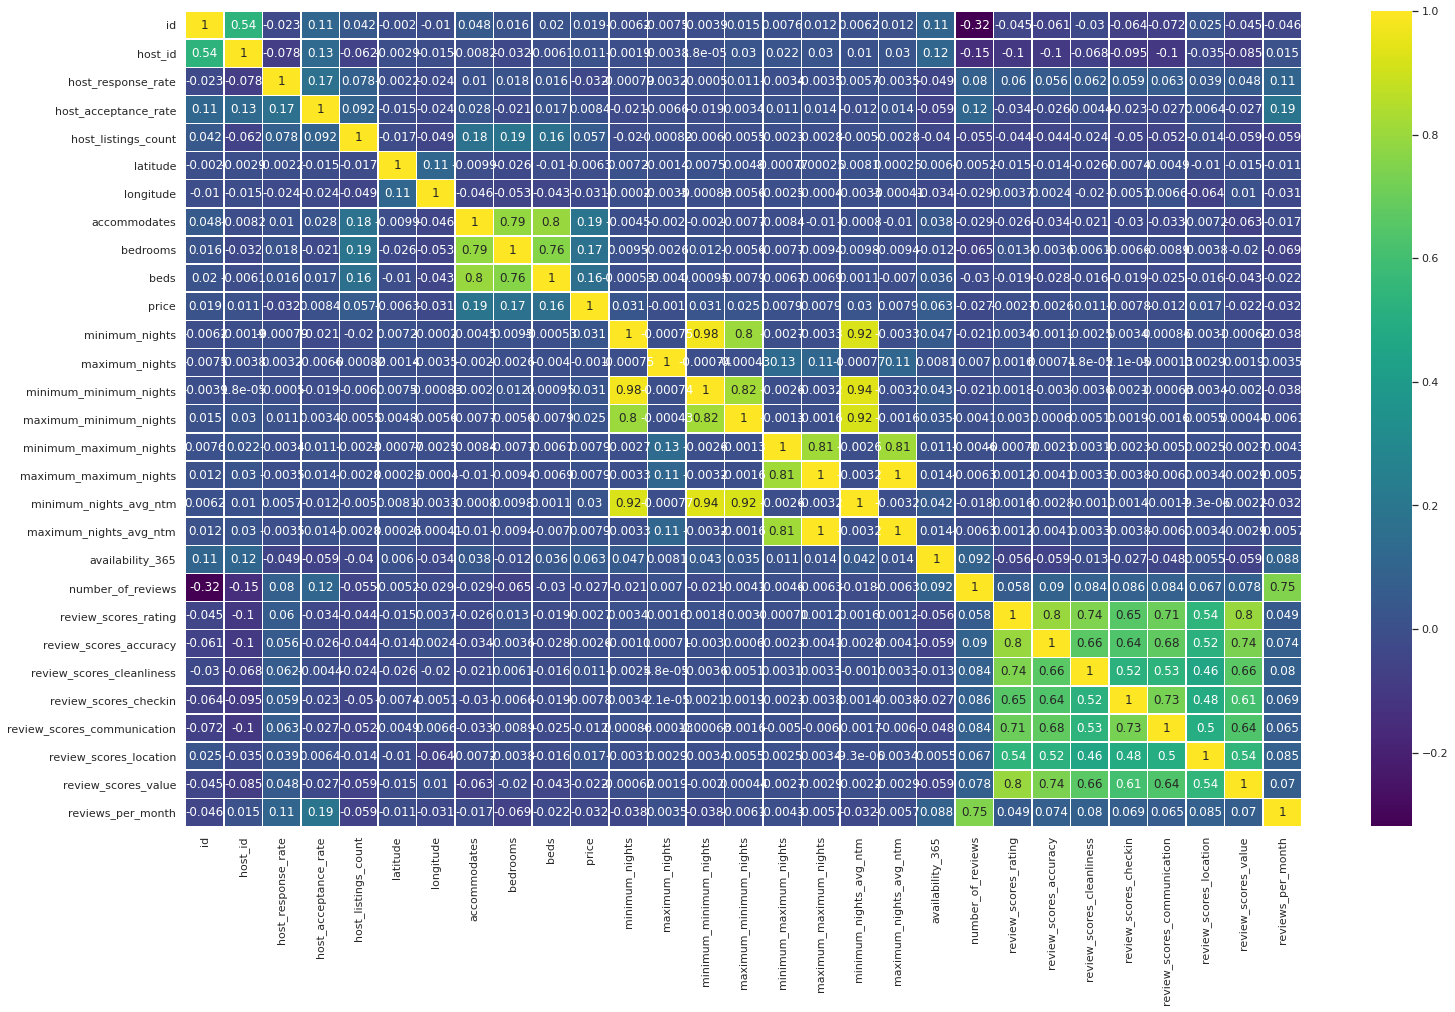

In [ ]:
# Plot a heatmap to visualize the correlation between different features
fig, ax = plt.subplots(figsize=(25,15))  
sns.heatmap(df.corr(), annot = True, cmap = 'viridis', linewidths=.5, ax=ax)

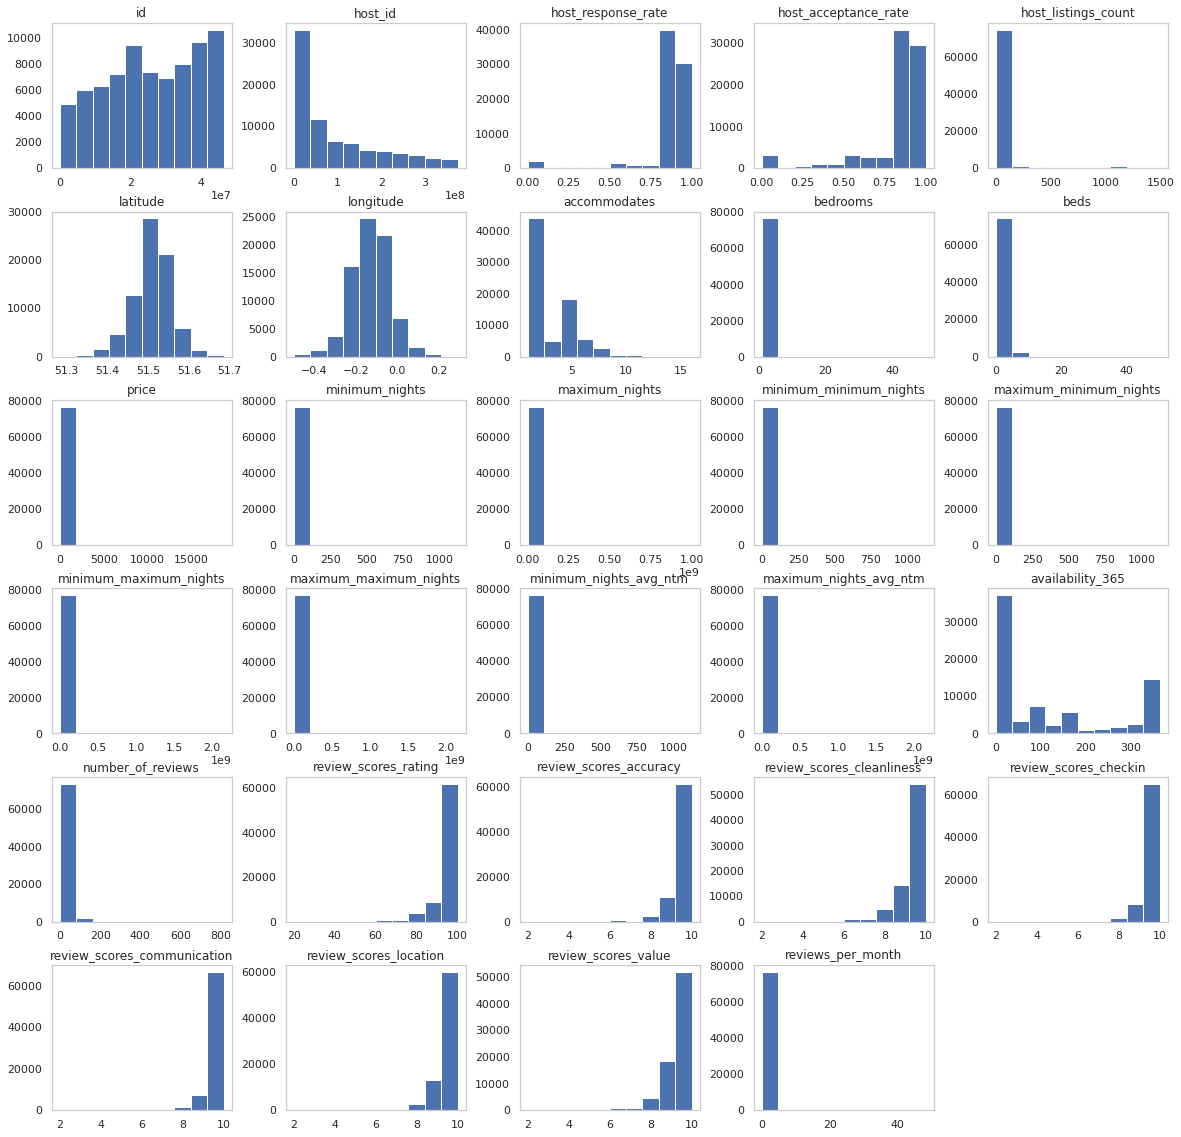

In [ ]:
# Create histograms to visualize the distribution of numerical data
df.hist(figsize=(20,20), grid=False);

In [ ]:
# Let's see which host_ids have the most listings on Airbnb
top_hosts = df.host_id.value_counts().head(10)
top_host_df = pd.DataFrame(top_hosts)
top_host_df.reset_index(inplace=True)
top_host_df.rename(columns={'index':'host_id', 'host_id':'listings_count'}, 
                   inplace=True)
top_host_df

,host_id,listings_count
0,33889201,878
1,137094377,283
2,13557337,279
3,48165024,267
4,28820321,242
5,224866971,152
6,27572615,143
7,50291093,118
8,228928499,114
9,10961046,111


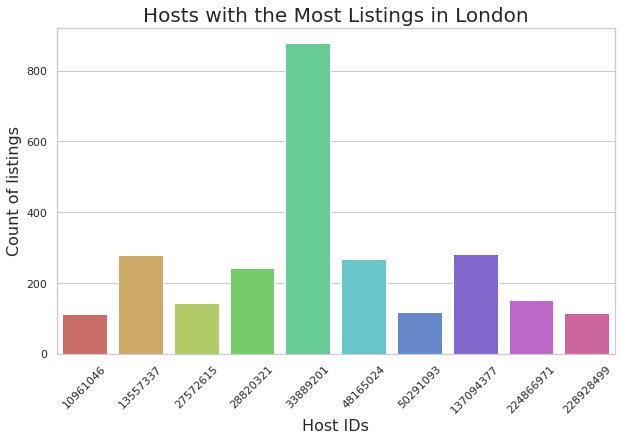

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(x="host_id", y="listings_count", data=top_host_df, palette='hls')
ax.set_title('Hosts with the Most Listings in London', fontsize=20)
ax.set_ylabel('Count of listings', fontsize=16)
ax.set_xlabel('Host IDs', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [ ]:
# Let's view the top 10 boroughs with the most number of listings
top_neighbourhoods = df.groupby(['neighbourhood_cleansed'])\
['host_listings_count'].count().nlargest(10)
top_neighbourhoods_df = pd.DataFrame(top_neighbourhoods)
top_neighbourhoods_df.reset_index(inplace=True)
top_neighbourhoods_df.rename(
    columns={'neighbourhood_cleansed':'borough', 
             'host_listings_count':'listings_count'}, 
             inplace=True)
top_neighbourhoods_df

,borough,listings_count
0,Westminster,8568
1,Tower Hamlets,6824
2,Hackney,5713
3,Kensington and Chelsea,5321
4,Camden,5254
5,Islington,4485
6,Lambeth,4399
7,Southwark,4319
8,Wandsworth,3935
9,Hammersmith and Fulham,3569


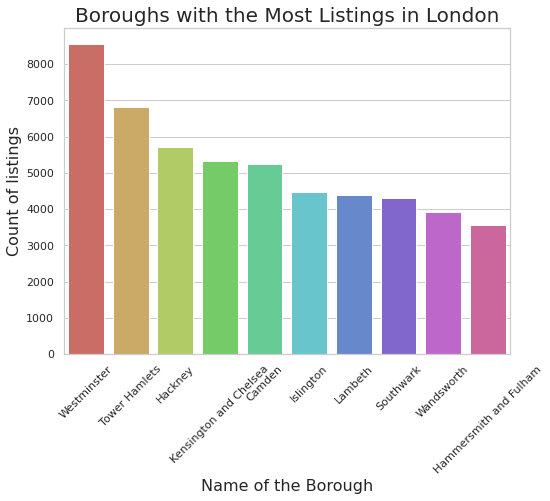

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.barplot(x="borough", y="listings_count", 
            data=top_neighbourhoods_df, palette='hls')
ax.set_title('Boroughs with the Most Listings in London', fontsize=20)
ax.set_ylabel('Count of listings', fontsize=16)
ax.set_xlabel('Name of the Borough', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

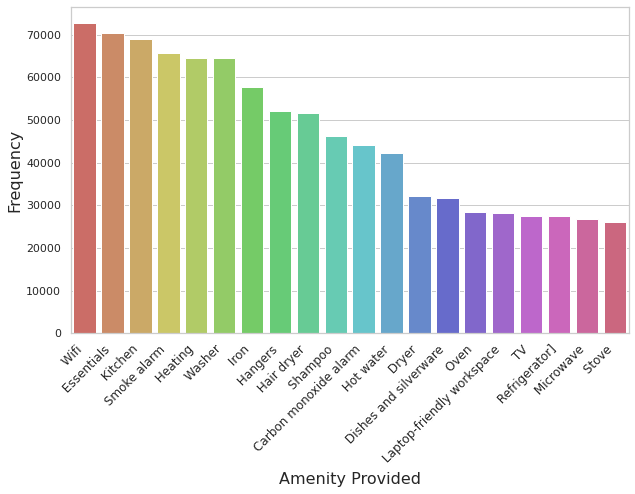

In [ ]:
# Let's clean the column amenities and plot it
df.loc[:, 'amenities'] = df.amenities.str.replace('"', "")
df.reset_index(inplace=True, drop=True)
data = pd.Series(np.concatenate(df['amenities']\
                         .map(lambda amns: amns.split(","))))\
                         .value_counts().head(20).reset_index()
data.rename(columns={'index':'amenity', 0:'frequency'}, inplace=True)
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(y='frequency', x='amenity', data=data, palette='hls')
ax = plt.gca()
ax.set_ylabel('Frequency', fontsize=16)
ax.set_xlabel('Amenity Provided', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12);

The above chart shows that certain amenitites such as wifi, kitchen, heating, smoke alarms, washers and so on are common to most listings.

In [ ]:
# Let's see whether amenities provided has an impact on the price of a listing.
list_of_amenities = np.unique(np.concatenate(df['amenities']
                                             .map(lambda amns: amns.split(",")
                                             )))[1:]
amenity_arr = np.array([df['amenities']
                        .map(lambda amns: amn in amns) 
                        for amn in list_of_amenities])
amenity_arr

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

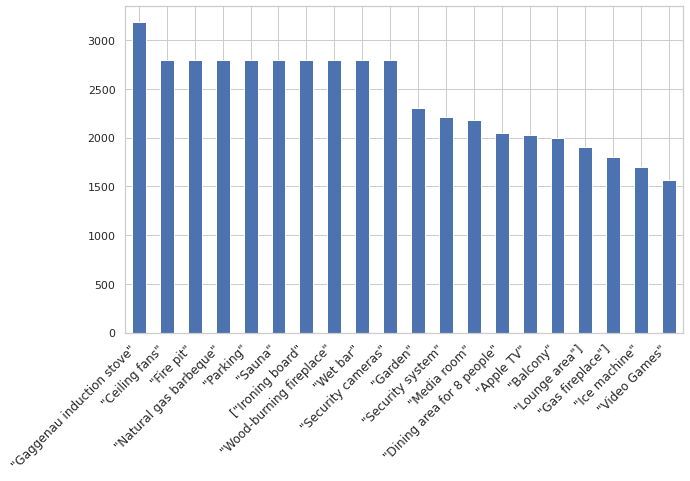

In [ ]:
# Let's create a chart to visualise the relationship between listing price and 
# amenities provided
df = df_cleaned.copy()
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)

amenities = np.unique(np.concatenate(df['amenities']
                                     .map(lambda amns: amns.split(","))))[1:]
amenity_prices = [(amn, df[df['amenities']
                           .map(lambda amns: amn in amns)]['price']
                   .mean()) for amn in amenities if amn != ""]
# Plot the chart
fig, ax = plt.subplots(1, figsize=(10, 6))
s_amenity = pd.Series(data=[a[1] for a in amenity_prices], 
                        index=[a[0] for a in amenity_prices])
s_amenity.sort_values(ascending=False)[:20].plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

* **The above chart shows that listings with certain amenities which are uncommon such as a fire pit, parking, sauna and so on have a higher price.**

## Modelling

### 1.   Which neighbourhoods have the most expensive listings in London?
#### Let's analyse the feature named **price**







In [ ]:
df = df_cleaned.copy()
# To have a more representative dataset, let's remove outliers of 'price' from 
# the lowest 1% and highest 1%. Let's also remove these records 
# from 'latitude' and 'longitude'
df = df[(df['price'] >= np.percentile(df['price'], 1)) & 
 (df['price'] <= np.percentile(df['price'], 99)) & 
 (df['latitude'] >= np.percentile(df['latitude'], 1)) & 
 (df['latitude'] <= np.percentile(df['latitude'], 99)) &
 (df['longitude'] >= np.percentile(df['longitude'], 1)) & 
 (df['longitude'] <= np.percentile(df['longitude'], 99))]

Percentage of Records Filtered Out: 5.8 %


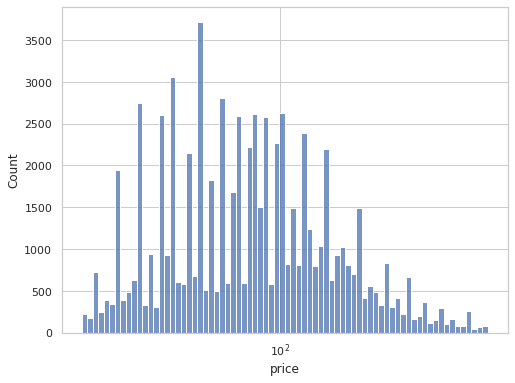

In [ ]:
# Let's create a histplot to view the distribution of prices
fig, ax = plt.subplots(1, figsize=(8, 6))
sns.histplot(x = 'price', log_scale=True, data=df)
value = (1 - df.shape[0]/london_listings.shape[0]) * 100
print('Percentage of Records Filtered Out: {:.1f} %'.format(value))

*   **From the above histplot, it can observed that Airbnb rentals have a wide spread of prices.**

In [ ]:
# Let's project airbnb rental prices in different neighbourhoods 
# over a map of London. We will make use of GeoPandas for this operation.
# Import map_df
fp = '/content/drive/MyDrive/data-science/datasets/airbnb-london/\
gis-files/London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)
map_df.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [ ]:
data_for_map = df[['neighbourhood_cleansed', 'price', 'host_id']]

# merge the dataframes 'map_df' & 'data_for_map'
merged = map_df.set_index('NAME')\
.join(data_for_map.set_index('neighbourhood_cleansed'))
merged.head()

,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,price,host_id
Barking and Dagenham,E09000002,3779.934,169.15,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",39.0,967537.0
Barking and Dagenham,E09000002,3779.934,169.15,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",85.0,290846.0
Barking and Dagenham,E09000002,3779.934,169.15,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",28.0,26545748.0
Barking and Dagenham,E09000002,3779.934,169.15,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",115.0,27774033.0
Barking and Dagenham,E09000002,3779.934,169.15,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",130.0,27774033.0


#### Visualising the feature **price**

CPU times: user 51.7 s, sys: 808 ms, total: 52.5 s
Wall time: 52.5 s


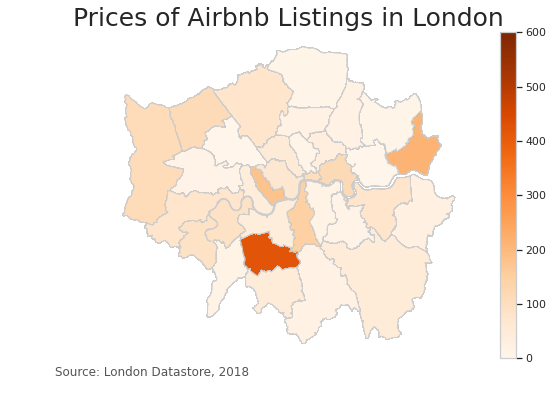

In [ ]:
%%time
# set a variable that will call whatever column we want to visualise on the map
variable = 'price'
# set the range for the choropleth
vmin, vmax = 0, 600
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
merged.plot(column=variable, cmap='Oranges', 
            linewidth=0.8, ax=ax, edgecolor='0.8')
# Turn off the axis
ax.axis('off')
# add a title
ax.set_title('Prices of Airbnb Listings in London', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: London Datastore, 2018',
            xy=(0.1, .08),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Oranges', 
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
# fig.savefig(“map_export.png”, dpi=300)

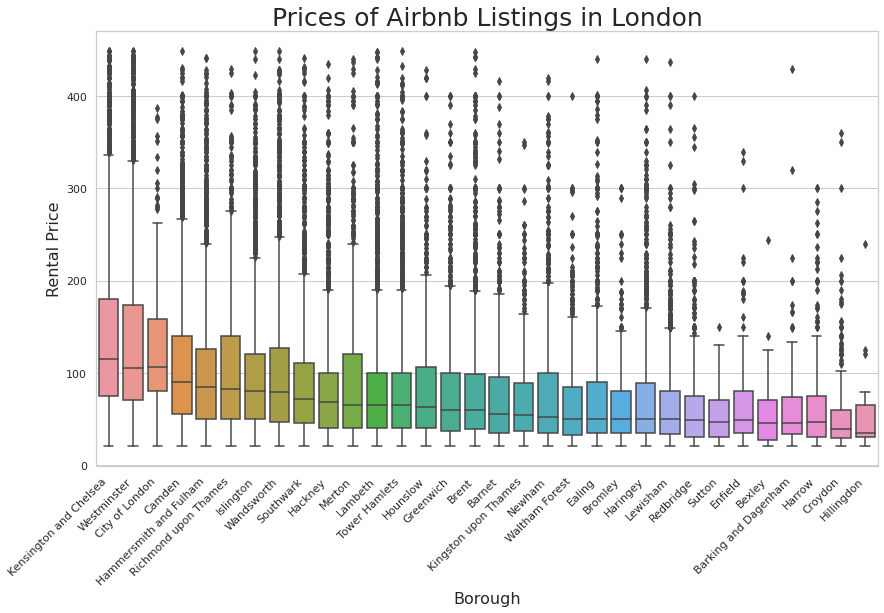

In [ ]:
sort_price = df.loc[(df.price <= 600) & (df.price >= 0)]\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index

fig, ax = plt.subplots(1, figsize=(14, 8))
ax.set_title('Prices of Airbnb Listings in London', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})
sns.boxplot(y='price', x='neighbourhood_cleansed', 
            data=df.loc[(df.price <= np.percentile(df.price, 99)) & 
                        (df.price >= np.percentile(df.price, 1))], 
            order=sort_price)
ax = plt.gca()
plt.ylabel('Rental Price', fontsize=16)
plt.xlabel('Borough', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

#### Explaining the visualisation

*  The chart above shows the prices of listings in each borough sorted in decending order. **We can see that Airbnb listings in certain boroughs have a higher rental price because of their prime locations.** This is as expected since property values towards the city center tend to be higher than in the suburbs. 

### 2.   What features influence the price of a listing?
#### Prepare the data for modelling

In [ ]:
df = df_cleaned.copy()
# Let's grab the categorical columns
cat_df = df.select_dtypes(include=['object'])

In [ ]:
# Let's get dummy variables for all categorical columns
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical 
                columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical 
                columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for 
                the NaN values
            5. Use a prefix of the column name with an underscore (_) for 
                separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), 
                            pd.get_dummies(df[col], 
                                           prefix=col, 
                                           prefix_sep='_', 
                                           drop_first=True, 
                                           dummy_na=dummy_na)
                            ], axis=1)
        except:
            continue
    return df

In [ ]:
# Create a sample so that sample size can be changed if your system faces
# memory overload.
df_slice = df.sample(frac=.6, replace=False, random_state=42)

# Drop columns that will not be a part of the model
df_slice.drop(columns={'id','host_id','host_since','amenities'}, inplace=True)
df_slice.shape

(46094, 36)

In [ ]:
# Call the function create_dummy_df
cat_cols_list = cat_df.columns
df_dummy = create_dummy_df(df_slice, cat_cols_list, 
                           dummy_na=False).reset_index(drop=True)

#### Checkpoint - 3


In [ ]:
# Checkpoint - 3
df = df_dummy.copy()
df.head()

,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,...,bathrooms_text_0 shared baths,bathrooms_text_1 bath,bathrooms_text_1 private bath,bathrooms_text_1 shared bath,bathrooms_text_1.5 baths,bathrooms_text_1.5 shared baths,bathrooms_text_10 baths,bathrooms_text_10.5 baths,bathrooms_text_11 baths,bathrooms_text_12 baths,bathrooms_text_2 baths,bathrooms_text_2 shared baths,bathrooms_text_2.5 baths,bathrooms_text_2.5 shared baths,bathrooms_text_3 baths,bathrooms_text_3 shared baths,bathrooms_text_3.5 baths,bathrooms_text_3.5 shared baths,bathrooms_text_35 baths,bathrooms_text_4 baths,bathrooms_text_4 shared baths,bathrooms_text_4.5 baths,bathrooms_text_4.5 shared baths,bathrooms_text_5 baths,bathrooms_text_5 shared baths,bathrooms_text_5.5 baths,bathrooms_text_6 baths,bathrooms_text_6 shared baths,bathrooms_text_6.5 baths,bathrooms_text_7 baths,bathrooms_text_7 shared baths,bathrooms_text_7.5 baths,bathrooms_text_8 baths,bathrooms_text_8 shared baths,bathrooms_text_8.5 baths,bathrooms_text_9 baths,bathrooms_text_Half-bath,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath,instant_bookable_t
0,0.500000,0.770000,3.0,51.58067,-0.23479,9,2.0,5.0,198,4,1125,4,28,1125,1125,5.7,1125.0,0,24,82.000000,8.000000,8.000000,9.000000,9.000000,8.000000,8.000000,0.94,0,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.000000,0.560000,2.0,51.47619,-0.10245,2,1.0,1.0,24,50,60,50,50,60,60,50.0,60.0,29,14,80.000000,9.000000,7.000000,10.000000,9.000000,9.000000,9.000000,0.25,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.000000,1.000000,0.0,51.36131,-0.14589,1,1.0,1.0,32,1,10,1,28,10,10,2.8,10.0,67,1,93.104647,9.533287,9.292053,9.653809,9.677272,9.559785,9.305253,0.10,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.000000,0.410000,294.0,51.51141,-0.14687,1,1.0,1.0,335,3,1125,3,28,1125,1125,4.8,1125.0,364,0,93.104647,9.533287,9.292053,9.653809,9.677272,9.559785,9.305253,0.00,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.876455,0.812695,1.0,51.59158,-0.07798,2,1.0,1.0,20,1,1125,1,28,1125,1125,2.9,1125.0,0,2,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.06,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


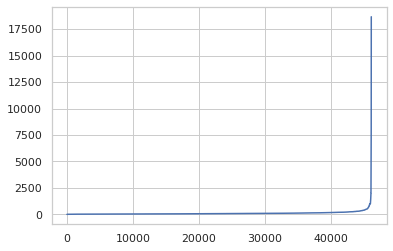

In [ ]:
# Let's take a look at the distribution of prices
df['price'].sort_values().reset_index(drop=True).plot()

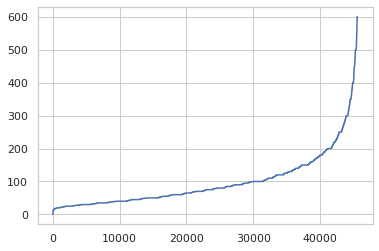

In [ ]:
# Let's filter out prices more than 600
df_model = df.query('price <= 600')
df_model['price'].sort_values().reset_index(drop=True).plot()

#### Checkpoint - 4

In [ ]:
# Checkpoint - 4
df = df_model.copy()
df.shape

(45602, 186)

#### **Choosing a Model**
##### We will try to model the data using the following machine learning models:

1.   Linear Regression Model
2.   Random Forest Regressor Model
3.   LGBM Regressor Model

The choice of regression models is arbitrary. We will check the accuracy of each model before making a decision on the best model for our business case.


##### _Linear Regression Model_

In [ ]:
# Create a linear model
lm_model = LinearRegression(normalize=True)
y = df['price']
lm_model.fit(df.drop('price', axis='columns'), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
y_pred = lm_model.predict(df.drop('price', axis='columns'))
mse = mean_squared_error(y, y_pred)
mse

3160.6154950441596

In [ ]:
# Let's take a look at the RMSE
rmse_lm = mse**(1/2)
rmse_lm

56.21935160640115

In [ ]:
# Let's check the value of the r2_score
r_squared_lm = r2_score(y, y_pred)
r_squared_lm

0.5302944490989852

In [ ]:
# Let's take a look at the coefficients to find the most important features
coefs = pd.DataFrame(zip(lm_model.coef_, df.drop('price', axis='columns')))
coefs.rename(columns={0:'coefs', 1:'feature'}, inplace=True)
coefs.sort_values(by='coefs', ascending=False, inplace=True)
coefs.head(20)

,coefs,feature
65,355.629513,property_type_Dome house
128,206.432343,property_type_Shared room in boutique hotel
173,154.633582,bathrooms_text_6.5 baths
84,152.789542,property_type_Island
141,151.092819,property_type_Yurt
166,143.337554,bathrooms_text_4.5 baths
131,122.974935,property_type_Shared room in farm stay
170,122.576830,bathrooms_text_5.5 baths
93,106.387764,property_type_Private room in castle
161,83.585697,bathrooms_text_3.5 baths


*  **The RMSE value of the Linear Model is 56. Let's try another model, the Random Forest Regressor Model to check if it proves to be a better model for our data.**

##### _Random Forest Regressor Model_

In [ ]:
%%time
df = df_model.copy()

Y = df_model['price']
X = df_model.drop('price', axis =1)

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.25, 
                                                    random_state=42)
# Create the model
rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
# Fit the model
rf.fit(X_train, y_train)

# Get the predicted values
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate RMSE
rmse_rf = (mean_squared_error(y_test,y_test_pred))**(1/2)

CPU times: user 9min 16s, sys: 2.01 s, total: 9min 18s
Wall time: 4min 51s


In [ ]:
# Let's take a look at the RMSE
rmse_rf

49.92170223916295

*  **The RMSE value is 50, better than that of the Linear Model.**




In [ ]:
# Let's check the value of the r2_score
r_squared_rf = r2_score(y_test, y_test_pred)
r_squared_rf

0.6200801357006961

 *   **The model explains 62% of the variability in listing price, by Random Forest Regressor.**



In [ ]:
# Let's take a look at the coefficients to find the most important features
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df = coefs_df.sort_values('coefs', ascending=False)\
.head(20).reset_index(drop=True)
coefs_df

,est_int,coefs
0,bedrooms,0.300208
1,room_type_Private room,0.068810
2,longitude,0.067604
3,latitude,0.059846
4,accommodates,0.052077
5,host_listings_count,0.042545
6,availability_365,0.035129
7,reviews_per_month,0.028712
8,host_acceptance_rate,0.021827
9,neighbourhood_cleansed_Westminster,0.020352


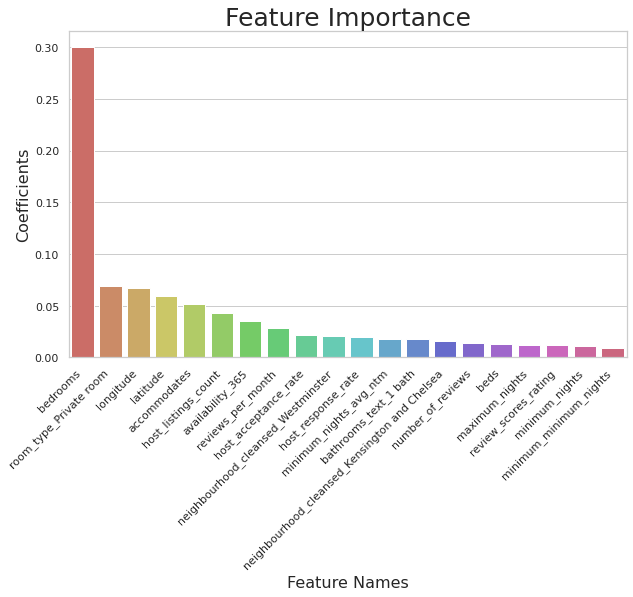

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Feature Importance', 
             fontdict={'fontsize': '25', 'fontweight' : '3'})
sns.barplot(y='coefs', x='est_int', data=coefs_df, palette='hls')
plt.ylabel('Coefficients', fontsize=16)
plt.xlabel('Feature Names', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

*   **The above figure shows the weight of each feature with respect to the price. From the above visualisation we can see that the following features are three most important features that influence the price of a listing. They are:**
> 1.  Bedrooms
> 2.  Type of room
> 3.  Location



##### _LGBM Regressor Model_

In [ ]:
%%time
listings_new = df_model.copy()

y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.25, 
                                                    random_state=42)
fit_params={
    "early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto'
           }
        
class LGBMRegressor_GainFE(LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError \
            ('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')
        
clf = LGBMRegressor_GainFE(num_leaves= 25, max_depth=20, 
                         random_state=42, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)
clf.fit(X_train.values, y_train.values, **fit_params)
y_pred = clf.predict(X_test.values)
print('R^2 test: %.2f' % (r2_score(y_test, y_pred)))

Training until validation scores don't improve for 20 rounds.
[100]	valid's rmse: 60.293
[200]	valid's rmse: 54.6135
[300]	valid's rmse: 52.2958
[400]	valid's rmse: 50.8711
[500]	valid's rmse: 50.0501
[600]	valid's rmse: 49.5474
[700]	valid's rmse: 49.19
[800]	valid's rmse: 48.92
[900]	valid's rmse: 48.7417
[1000]	valid's rmse: 48.5841
Did not meet early stopping. Best iteration is:
[1000]	valid's rmse: 48.5841
R^2 test: 0.64
CPU times: user 21.8 s, sys: 2.82 s, total: 24.6 s
Wall time: 14.4 s


### Explaining the Model

* The LGBM Regressor Model yields an RMSE value of **48.58**, by far the best 
value in the three models we have explored. The model **explains 64% (R^2 test: 0.640)** of the variability in listing price.

### 3. What is the percentage of positive reviews for the top 20 most reviewed listings in London?

In [ ]:
# Read the data from Airbnb listings in Amsterdam into a Pandas DataFrame
f2_name='/content/drive/MyDrive/data-science/datasets/airbnb-london/reviews.csv'
london_reviews = pd.read_csv(f2_name)
df_reviews = london_reviews.copy()

In [ ]:
# Checkpoint - 5
df = df_reviews.copy()

# Print the number of records in the DataFrame
print("No.of.records - {} \n".format(df_reviews.shape))
df_reviews.head()

No.of.records - (1199654, 6) 



,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...
2,11551,41044,2010-05-09,104133,Chase,Adriano was a fantastic host. We felt very at ...
3,11551,48926,2010-06-01,122714,John & Sylvia,We had a most wonderful stay with Adriano and ...
4,11551,58352,2010-06-28,111543,Monique,I'm not sure which of us misunderstood the s...


In [ ]:
# Let's remove the columns that will not be used for analysis
df.drop(columns={'id', 'reviewer_id', 'reviewer_name', 'date'}, inplace=True)
df.head()

,listing_id,comments
0,11551,"The flat was bright, comfortable and clean and..."
1,11551,We stayed with Adriano and Valerio for a week ...
2,11551,Adriano was a fantastic host. We felt very at ...
3,11551,We had a most wonderful stay with Adriano and ...
4,11551,I'm not sure which of us misunderstood the s...


In [ ]:
# Get the top 20 listings that have the highest number of reviews
df_top_20 = df.listing_id.value_counts().nlargest(20).reset_index()
df_top_20.rename(columns={'index':'listing_id', 'listing_id':'review_count'}, 
                inplace=True)
df_top_20.head()

,listing_id,review_count
0,1436172,813
1,1436177,711
2,9046849,711
3,604185,650
4,2126708,648


In [ ]:
df_merged = pd.merge(df_top_20, df, how='left', on='listing_id')
df_merged.sort_values(by=['review_count'], ascending=False, inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.dropna(inplace=True)
df_merged.tail()

,listing_id,review_count,comments
11980,2025844,523,Nice house nice location !!楼下有超市餐厅 对面就是地铁站 距离大...
11981,2025844,523,We had an excellent stay at Mark's apartment. ...
11982,2025844,523,Our stay in Mark's apartment went very well! H...
11983,2025844,523,The place is 1st class for style/quality. The ...
11984,2025844,523,"I loved the place. It is centrally located, an..."


In [ ]:
# Let's check if we have the top 20 unique listing ids
len(df_merged.listing_id.unique())

20

In [ ]:
sid = SentimentIntensityAnalyzer()
for sentence in df_merged['comments'].values[:5]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

Convenient location, pleasant stay, reasonable price, and oh, good cup of coffee. I enjoyed breakfast in the backyard. Paul is a good host.
compound: 0.9081, neg: 0.0, neu: 0.578, pos: 0.422, 
Very good location to train stations and buses. Safe to walk.
compound: 0.7264, neg: 0.0, neu: 0.596, pos: 0.404, 
This property is a lovely place to stay. It is very close to the station and restaurants nearby. It was unfortunate that we couldn’t meet paul as we had early flights. I would definately recommend this place to friends and family. Joyce checked us in and was very friendly, she answered all of our questions. 
We would definately like to stay here again. 
compound: 0.908, neg: 0.041, neu: 0.749, pos: 0.21, 
Paul was very responsive and very  helpful to ensure that I will arrive his place without any issue and how get in through the gate.  Thanks Paul !
compound: 0.8988, neg: 0.0, neu: 0.648, pos: 0.352, 
This was our first time at an air bnb so we were quite unsure of what to expect.  

In [ ]:
# Get the pscores
pscores = [sid.polarity_scores(comment) for comment in df_merged['comments']]

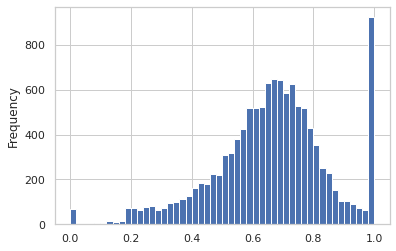

In [ ]:
# Neutral Sentiment
pd.Series([score['neu'] for score in pscores]).plot(kind='hist', bins=50)

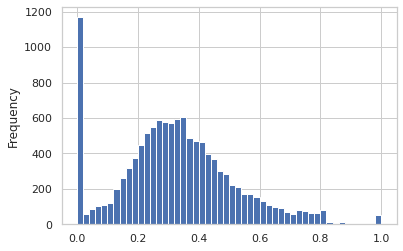

In [ ]:
# Positive Sentiment
pd.Series([score['pos'] for score in pscores]).plot(kind='hist', bins=50)

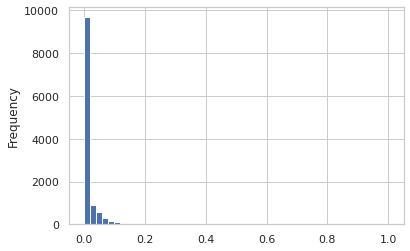

In [ ]:
# Negative Sentiment
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', bins=50)

*   **From the charts above, we can see that a very few text are classified as having negativity, whereas, a significant number of texts are classified as either being positive or neutral.**

## Evaluation
### Findings

1.   Airbnb hosts with listings in prime locations charge a premium.
2.   The number of available bedrooms has the greatest weight in determining the price of an Airbnb rental. A listing earns $30 more on each additional room.
3.   Most reviews posted on Airbnb have a positive sentiment.

